In [29]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter  # Ensure you have installed pykalman (pip install pykalman)

class MomentumStrategy:
    def __init__(self, price_data, leverage, initial_portfolio_value):
        """
        Initialize the MomentumStrategy.

        Parameters:
        - price_data (DataFrame): DataFrame with timestamp-indexed asset prices.
        - leverage (float): Leverage factor for trades.
        - initial_portfolio_value (float): Starting portfolio value.
        """
        self.price_data = price_data.copy()
        self.leverage = leverage
        self.initial_portfolio_value = initial_portfolio_value
        # Initialize trade logs for each market (asset) except for a potential 'time' column.
        self.trade_logs = {asset: pd.DataFrame(columns=['timestamp', 'type', 'price', 
                                                         'ema', 'sma', 'ema_slope', 'sma_slope', 'return'])
                           for asset in self.price_data.columns if asset != 'time'}

    def calculate_kalman_filter(self, price_series, initial_state=None, process_var=1e-5, meas_var=0.1):
        """
        Calculate the Kalman filter estimate of the price series using pykalman.
        
        Parameters:
        - price_series (Series): Asset price series.
        - initial_state (float): Initial state estimate (defaults to first price).
        - process_var (float): Process variance (system noise).
        - meas_var (float): Measurement variance (sensor noise).
        
        Returns:
        - Series: Kalman-filtered estimates.
        """
        if initial_state is None:
            initial_state = price_series.iloc[0]
        
        kf = KalmanFilter(
            transition_matrices=[1],
            observation_matrices=[1],
            initial_state_mean=initial_state,
            initial_state_covariance=1.0,
            transition_covariance=process_var,
            observation_covariance=meas_var
        )
        state_means, _ = kf.filter(price_series.values)
        return pd.Series(state_means.flatten(), index=price_series.index)
        
    def calculate_moving_avg(self, price_series, window):
        """
        Calculate the simple moving average (SMA) of the price series.

        Parameters:
        - price_series (Series): Asset price series.
        - window (int): Window size for the moving average.

        Returns:
        - Series: SMA series.
        """
        return price_series.rolling(window=window).mean()

    def calculate_exponential_moving_avg(self, price_series, span):
        """
        Calculate the exponential moving average (EMA) of the price series.

        Parameters:
        - price_series (Series): Asset price series.
        - span (int): Lookback period for the EMA.

        Returns:
        - Series: EMA series.
        """
        return price_series.ewm(span=span, adjust=False).mean()

    def calculate_percentage_slope(self, moving_avg_series):
        """
        Calculate the percentage slope of a moving average series.

        Parameters:
        - moving_avg_series (Series): Moving average series.

        Returns:
        - Series: Percentage change (slope) values.
        """
        slope = (moving_avg_series.diff(1) / moving_avg_series.shift(1)) * 100
        return slope.fillna(0)

    def simulate_trade_with_percentage_slope(self, market, position_size, entry_threshold, exit_threshold, window=None, use_kalman=False, kalman_params=None):
        """
        Simulate trading for a single market using a single moving average (and its slope)
        strategy (your original approach).

        Parameters:
        - market (str): Market (asset) name.
        - position_size (float): Position size.
        - entry_threshold (float): Slope threshold to enter a trade.
        - exit_threshold (float): Slope threshold to exit a trade.
        - window (int): Window for SMA calculation.
        - use_kalman (bool): Whether to use a Kalman filter.
        - kalman_params (dict): Parameters for the Kalman filter.
        
        Returns:
        - float: Final portfolio value after trading.
        """
        price_series = self.price_data[market]
        if use_kalman:
            kalman_params = kalman_params or {}
            filtered_series = self.calculate_kalman_filter(price_series, **kalman_params)
        else:
            filtered_series = self.calculate_moving_avg(price_series, window)
            slope_series = self.calculate_percentage_slope(filtered_series)
        slope_series = slope_series.fillna(0)
        portfolio_value = self.initial_portfolio_value
        in_position = False
        position_type = None  # "long" or "short"
        entry_price = 0.0

        for idx in range(len(self.price_data)):
            current_slope = slope_series.iloc[idx]
            current_price = price_series.iloc[idx]
            current_time = slope_series.index[idx]

            # Entry Conditions
            if not in_position:
                if current_slope >= entry_threshold:
                    in_position = True
                    position_type = "long"
                    entry_price = current_price
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_entry',
                        'price': entry_price,
                        'ema': np.nan,
                        'sma': np.nan,
                        'ema_slope': current_slope,
                        'sma_slope': current_slope,
                        'return': np.nan
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                elif current_slope <= -entry_threshold:
                    in_position = True
                    position_type = "short"
                    entry_price = current_price
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_entry',
                        'price': entry_price,
                        'ema': np.nan,
                        'sma': np.nan,
                        'ema_slope': current_slope,
                        'sma_slope': current_slope,
                        'return': np.nan
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
            else:
                if position_type == "long" and current_slope <= exit_threshold:
                    price_change = (current_price - entry_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_exit',
                        'price': current_price,
                        'ema': np.nan,
                        'sma': np.nan,
                        'ema_slope': current_slope,
                        'sma_slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                    in_position, position_type, entry_price = False, None, 0.0
                elif position_type == "short" and current_slope >= -exit_threshold:
                    price_change = (entry_price - current_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_exit',
                        'price': current_price,
                        'ema': np.nan,
                        'sma': np.nan,
                        'ema_slope': current_slope,
                        'sma_slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                    in_position, position_type, entry_price = False, None, 0.0

        # Exit any open position at the end of the series.
        if in_position:
            final_price = price_series.iloc[-1]
            final_time = slope_series.index[-1]
            if position_type == "long":
                price_change = (final_price - entry_price) / entry_price
                trade_type = 'long_exit'
            elif position_type == "short":
                price_change = (entry_price - final_price) / entry_price
                trade_type = 'short_exit'
            leveraged_return = price_change * position_size * self.leverage
            trading_fee = position_size * self.leverage * 0.001
            trade_return = leveraged_return - trading_fee
            portfolio_value += trade_return
            new_row = pd.DataFrame([{
                'timestamp': final_time,
                'type': trade_type,
                'price': final_price,
                'ema': np.nan,
                'sma': np.nan,
                'ema_slope': current_slope,
                'sma_slope': current_slope,
                'return': trade_return
            }])
            self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)

        return portfolio_value

    def simulate_trade_with_ema_sma(self, market, position_size,
                                    ema_entry_threshold,
                                    ema_exit_threshold,
                                    ema_span, sma_window):
        """
        Simulate trading for a single market using an EMA–SMA crossover strategy with
        separate slope thresholds for EMA and SMA.
        
        Entry Conditions:
          - Long: When the previous EMA is below the previous SMA and the current EMA
            crosses above the current SMA, with both EMA and SMA slopes above their entry thresholds.
          - Short: When the previous EMA is above the previous SMA and the current EMA
            crosses below the current SMA, with both EMA and SMA slopes below the negative of their entry thresholds.
        
        Exit Conditions:
          - For a long position: Exit when a reversal crossover occurs and both slopes fall below their respective exit thresholds.
          - For a short position: Exit when a reversal crossover occurs and both slopes rise above their respective exit thresholds.
        
        Parameters:
        - market (str): Market (asset) name.
        - position_size (float): Position size.
        - ema_entry_threshold (float): Minimum EMA slope required to enter.
        - sma_entry_threshold (float): Minimum SMA slope required to enter.
        - ema_exit_threshold (float): EMA slope condition for exit.
        - sma_exit_threshold (float): SMA slope condition for exit.
        - ema_span (int): Lookback period for the EMA.
        - sma_window (int): Lookback period for the SMA.
        
        Returns:
        - float: Final portfolio value after trading.
        """
        price_series = self.price_data[market]
        ema_series = self.calculate_exponential_moving_avg(price_series, ema_span)
        sma_series = self.calculate_moving_avg(price_series, sma_window)

        portfolio_value = self.initial_portfolio_value
        in_position = False
        position_type = None
        entry_price = 0.0

        for i in range(1, len(price_series)):
            current_time = price_series.index[i]
            current_price = price_series.iloc[i]
            current_ema = ema_series.iloc[i]
            current_sma = sma_series.iloc[i]
            prev_ema = ema_series.iloc[i-1]
            prev_sma = sma_series.iloc[i-1]

            # Calculate slopes (percentage changes)
            ema_slope = ((current_ema - prev_ema) / prev_ema * 100) if prev_ema != 0 else 0
            sma_slope = ((current_sma - prev_sma) / prev_sma * 100) if prev_sma != 0 else 0

            # Entry Conditions
            if not in_position:
                # Long Entry: EMA crosses above SMA and both slopes exceed their entry thresholds.
                if (current_ema > current_sma and 
                    ema_slope > ema_entry_threshold):
                    in_position = True
                    position_type = "long"
                    entry_price = current_price
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_entry',
                        'price': entry_price,
                        'ema': current_ema,
                        'sma': current_sma,
                        'ema_slope': ema_slope,
                        'sma_slope': sma_slope,
                        'return': np.nan
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                # Short Entry: EMA crosses below SMA and both slopes are below their negative entry thresholds.
                elif (current_ema < current_sma and 
                      ema_slope < -ema_entry_threshold):
                    in_position = True
                    position_type = "short"
                    entry_price = current_price
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_entry',
                        'price': entry_price,
                        'ema': current_ema,
                        'sma': current_sma,
                        'ema_slope': ema_slope,
                        'sma_slope': sma_slope,
                        'return': np.nan
                    }])
                    self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
            else:
                # Exit Conditions
                if position_type == "long":
                    if (current_ema < current_sma or 
                        ema_slope < -ema_exit_threshold):
                        price_change = (current_price - entry_price) / entry_price
                        leveraged_return = price_change * position_size * self.leverage
                        trading_fee = position_size * self.leverage * 0.01
                        trade_return = leveraged_return - trading_fee
                        portfolio_value += trade_return
                        new_row = pd.DataFrame([{
                            'timestamp': current_time,
                            'type': 'long_exit',
                            'price': current_price,
                            'ema': current_ema,
                            'sma': current_sma,
                            'ema_slope': ema_slope,
                            'sma_slope': sma_slope,
                            'return': trade_return
                        }])
                        self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                        in_position, position_type, entry_price = False, None, 0.0
                elif position_type == "short":
                    if (current_ema > current_sma or 
                        ema_slope > ema_exit_threshold):
                        price_change = (entry_price - current_price) / entry_price
                        leveraged_return = price_change * position_size * self.leverage
                        trading_fee = position_size * self.leverage * 0.01
                        trade_return = leveraged_return - trading_fee
                        portfolio_value += trade_return
                        new_row = pd.DataFrame([{
                            'timestamp': current_time,
                            'type': 'short_exit',
                            'price': current_price,
                            'ema': current_ema,
                            'sma': current_sma,
                            'ema_slope': ema_slope,
                            'sma_slope': sma_slope,
                            'return': trade_return
                        }])
                        self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
                        in_position, position_type, entry_price = False, None, 0.0

        # Exit any open position at the end of the series.
        if in_position:
            final_price = price_series.iloc[-1]
            final_time = price_series.index[-1]
            if position_type == "long":
                price_change = (final_price - entry_price) / entry_price
                trade_type = 'long_exit'
            elif position_type == "short":
                price_change = (entry_price - final_price) / entry_price
                trade_type = 'short_exit'
            leveraged_return = price_change * position_size * self.leverage
            trading_fee = position_size * self.leverage * 0.001
            trade_return = leveraged_return - trading_fee
            portfolio_value += trade_return
            new_row = pd.DataFrame([{
                'timestamp': final_time,
                'type': trade_type,
                'price': final_price,
                'ema': ema_series.iloc[-1],
                'sma': sma_series.iloc[-1],
                'ema_slope': ema_slope,
                'sma_slope': sma_slope,
                'return': trade_return
            }])
            self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)

        return portfolio_value

    def trade_all_markets_with_percentage_slope(self, window, position_size, entry_threshold, exit_threshold, use_kalman=False, kalman_params=None):
        """
        Run the percentage-slope simulation across all markets.
        
        Parameters:
        - window (int): Window size for the SMA.
        - position_size (float): Position size.
        - entry_threshold (float): Entry threshold for the slope.
        - exit_threshold (float): Exit threshold for the slope.
        - use_kalman (bool): Whether to use the Kalman filter.
        - kalman_params (dict): Parameters for the Kalman filter.
        
        Returns:
        - float: Aggregate returns (sum of each market's returns).
        """
        total_returns = 0.0
        for market in self.price_data.columns:
            if market == 'time':
                continue
            final_portfolio = self.simulate_trade_with_percentage_slope(
                market=market,
                position_size=position_size,
                entry_threshold=entry_threshold,
                exit_threshold=exit_threshold,
                window=window,
                use_kalman=use_kalman,
                kalman_params=kalman_params
            )
            returns = final_portfolio - self.initial_portfolio_value
            total_returns += returns
        return total_returns

    def trade_all_markets_with_ema_sma(self, ema_span, sma_window, position_size, ema_entry_threshold, ema_exit_threshold):
        """
        Run the EMA–SMA crossover simulation across all markets.
        
        Parameters:
        - ema_span (int): Lookback period for the EMA.
        - sma_window (int): Lookback period for the SMA.
        - position_size (float): Position size.
        - ema_entry_threshold (float): Minimum EMA slope for entry.
        - sma_entry_threshold (float): Minimum SMA slope for entry.
        - ema_exit_threshold (float): EMA slope condition for exit.
        - sma_exit_threshold (float): SMA slope condition for exit.
        
        Returns:
        - float: Aggregate returns.
        """
        total_returns = 0.0
        for market in self.price_data.columns:
            if market == 'time':
                continue
            final_portfolio = self.simulate_trade_with_ema_sma(
                market=market,
                position_size=position_size,
                ema_entry_threshold=ema_entry_threshold,
                ema_exit_threshold=ema_exit_threshold,
                ema_span=ema_span,
                sma_window=sma_window
            )
            returns = final_portfolio - self.initial_portfolio_value
            total_returns += returns
        return total_returns

    def run_monte_carlo_simulation_with_percentage_slope(self, iterations, window_range, entry_threshold_range, exit_threshold_range, output_name, use_kalman=False, kalman_params=None, save_path='simulation_results'):
        """
        Run Monte Carlo simulations using the percentage slope strategy.
        
        Parameters:
        - iterations (int): Number of simulation iterations.
        - window_range (tuple): Range (min, max) for the moving average window.
        - entry_threshold_range (tuple): Range for entry thresholds.
        - exit_threshold_range (tuple): Range for exit thresholds.
        - output_name (str): Base name for the output JSON file.
        - use_kalman (bool): Whether to use the Kalman filter.
        - kalman_params (dict): Parameters for the Kalman filter.
        - save_path (str): Directory path to save simulation results.
        
        Returns:
        - list: List of simulation result dictionaries.
        """
        simulation_results = []

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i in range(iterations):
            WINDOW = np.random.randint(*window_range)
            POSITION_SIZE = 1
            ENTRY_THRESHOLD = np.random.uniform(*entry_threshold_range)
            EXIT_THRESHOLD = np.random.uniform(*exit_threshold_range)
            total_returns = self.trade_all_markets_with_percentage_slope(
                window=WINDOW,
                position_size=POSITION_SIZE,
                entry_threshold=ENTRY_THRESHOLD,
                exit_threshold=EXIT_THRESHOLD,
                use_kalman=use_kalman,
                kalman_params=kalman_params
            )
            simulation_results.append({
                'returns': total_returns,
                'window': WINDOW,
                'position_size': POSITION_SIZE,
                'entry_threshold': ENTRY_THRESHOLD,
                'exit_threshold': EXIT_THRESHOLD,
                'use_kalman': use_kalman,
                'kalman_params': kalman_params
            })
            if (i+1) % 10 == 0 or (i+1) == iterations:
                print(f"Completed {i+1}/{iterations} simulations.")

        with open(os.path.join(save_path, f'{output_name}_percentage_slope_simulation_results.json'), 'w') as f:
            json.dump(simulation_results, f, indent=4)

        return simulation_results

    def run_monte_carlo_simulation_with_ema_sma(self, iterations, window_range, ema_entry_threshold_range, ema_exit_threshold_range, output_name, save_path='simulation_results'):
        """
        Run Monte Carlo simulations using the EMA–SMA crossover strategy.
        
        Parameters:
        - iterations (int): Number of simulation iterations.
        - ema_span_range (tuple): Range (min, max) for EMA spans.
        - sma_window_range (tuple): Range (min, max) for SMA windows.
        - ema_entry_threshold_range (tuple): Range for EMA entry thresholds.
        - sma_entry_threshold_range (tuple): Range for SMA entry thresholds.
        - ema_exit_threshold_range (tuple): Range for EMA exit thresholds.
        - sma_exit_threshold_range (tuple): Range for SMA exit thresholds.
        - output_name (str): Base name for the output JSON file.
        - save_path (str): Directory path to save simulation results.
        
        Returns:
        - list: List of simulation result dictionaries.
        """
        simulation_results = []

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i in range(iterations):
            WINDOW = np.random.randint(*window_range)
            EMA_SPAN = WINDOW
            SMA_WINDOW = WINDOW
            POSITION_SIZE = 1
            EMA_ENTRY_THRESHOLD = np.random.uniform(*ema_entry_threshold_range)
            EMA_EXIT_THRESHOLD = np.random.uniform(*ema_exit_threshold_range)
            total_returns = self.trade_all_markets_with_ema_sma(
                ema_span=EMA_SPAN,
                sma_window=SMA_WINDOW,
                position_size=POSITION_SIZE,
                ema_entry_threshold=EMA_ENTRY_THRESHOLD,
                ema_exit_threshold=EMA_EXIT_THRESHOLD,
            )
            simulation_results.append({
                'returns': total_returns,
                'ema_span': EMA_SPAN,
                'sma_window': SMA_WINDOW,
                'position_size': POSITION_SIZE,
                'ema_entry_threshold': EMA_ENTRY_THRESHOLD,
                'ema_exit_threshold': EMA_EXIT_THRESHOLD,
            })
            if (i+1) % 10 == 0 or (i+1) == iterations:
                print(f"Completed {i+1}/{iterations} simulations.")

        with open(os.path.join(save_path, f'{output_name}_ema_sma_simulation_results.json'), 'w') as f:
            json.dump(simulation_results, f, indent=4)

        return simulation_results

    def plot_trade_histogram(self, market, profitability_axis='return', bins=50):
        """
        Plot a histogram of trade profitability for a specified market.
        
        Parameters:
        - market (str): Market identifier.
        - profitability_axis (str): The column to analyze for profitability (e.g., 'return').
        - bins (int): Number of bins for the histogram.
        """
        if market not in self.trade_logs:
            print(f"No trade data available for {market}.")
            return

        trades = self.trade_logs[market].sort_values(by='timestamp').reset_index(drop=True)
        paired_trades = []
        i = 0
        while i < len(trades) - 1:
            entry = trades.iloc[i]
            exit = trades.iloc[i+1]
            if ((entry['type'] in ['long_entry', 'short_entry']) and 
                ((entry['type'] == 'long_entry' and exit['type'] == 'long_exit') or 
                 (entry['type'] == 'short_entry' and exit['type'] == 'short_exit'))):
                if entry['type'] == 'long_entry':
                    profit = (exit['price'] - entry['price']) / entry['price'] * self.leverage
                else:
                    profit = (entry['price'] - exit['price']) / entry['price'] * self.leverage
                paired_trades.append(profit)
                i += 2
            else:
                i += 1

        if not paired_trades:
            print(f"No complete trade pairs to analyze for {market}.")
            return

        paired_trades = np.array(paired_trades)
        plt.figure(figsize=(10, 6))
        plt.hist(paired_trades, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Profitability Distribution for Trades in {market}')
        plt.xlabel('Profit/Loss (%)')
        plt.ylabel('Number of Trades')
        plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
        plt.show()

    def plot_trade_counts(self):
        """
        Plot the number of trades per asset.
        """
        trade_counts = {market: len(df) // 2 for market, df in self.trade_logs.items()}
        trade_counts = pd.Series(trade_counts)
        trade_counts.plot(kind='bar', figsize=(12, 6), color='lightgreen', edgecolor='black')
        plt.title('Number of Trades per Asset')
        plt.xlabel('Asset')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def save_trade_logs(self, save_path='trade_logs'):
        """
        Save trade logs for all assets to CSV files.
        
        Parameters:
        - save_path (str): Directory path to save trade logs.
        """
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for market, df in self.trade_logs.items():
            if not df.empty:
                df.to_csv(os.path.join(save_path, f'{market}_trade_log.csv'), index=False)
                print(f"Saved trade log for {market} to {save_path}.")
            else:
                print(f"No trades to save for {market}.")




In [33]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(6000), 50, 2000)

mc_results = strategy.run_monte_carlo_simulation_with_ema_sma(
        iterations=500,
        window_range=(100, 300),
        ema_entry_threshold_range=(0.03, 0.15),
        ema_exit_threshold_range=(-0.02, 0.019),
        output_name='ema_sma_test'
)

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [34]:
# Load the simulation results
with open('./simulation_results/ema_sma_test_ema_sma_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
187,230.656581,233,233,1,0.057826,0.013344
19,204.530266,217,217,1,0.074264,0.014124
403,197.123346,223,223,1,0.066348,0.012308
203,191.834493,204,204,1,0.080020,0.017298
361,188.635352,224,224,1,0.069796,0.013000
397,186.884615,281,281,1,0.047858,0.003814
201,178.390825,265,265,1,0.047480,0.005755
310,165.029683,260,260,1,0.058226,0.005080
331,163.683298,239,239,1,0.053940,0.007857
387,159.070146,271,271,1,0.057404,0.010890


In [35]:
sorted_df.tail(10)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
455,-940.293009,133,133,1,0.032195,-0.000126
206,-979.755345,143,143,1,0.031004,-0.005675
412,-1010.132650,114,114,1,0.041413,-0.006618
306,-1046.150658,119,119,1,0.037149,-0.004129
493,-1048.951220,120,120,1,0.040201,-0.015124
214,-1060.764850,122,122,1,0.033508,0.001432
86,-1145.647920,111,111,1,0.032379,0.004377
459,-1294.939001,110,110,1,0.038827,-0.019448
177,-1336.500057,104,104,1,0.039684,-0.019983
122,-1439.078081,101,101,1,0.031573,-0.005925


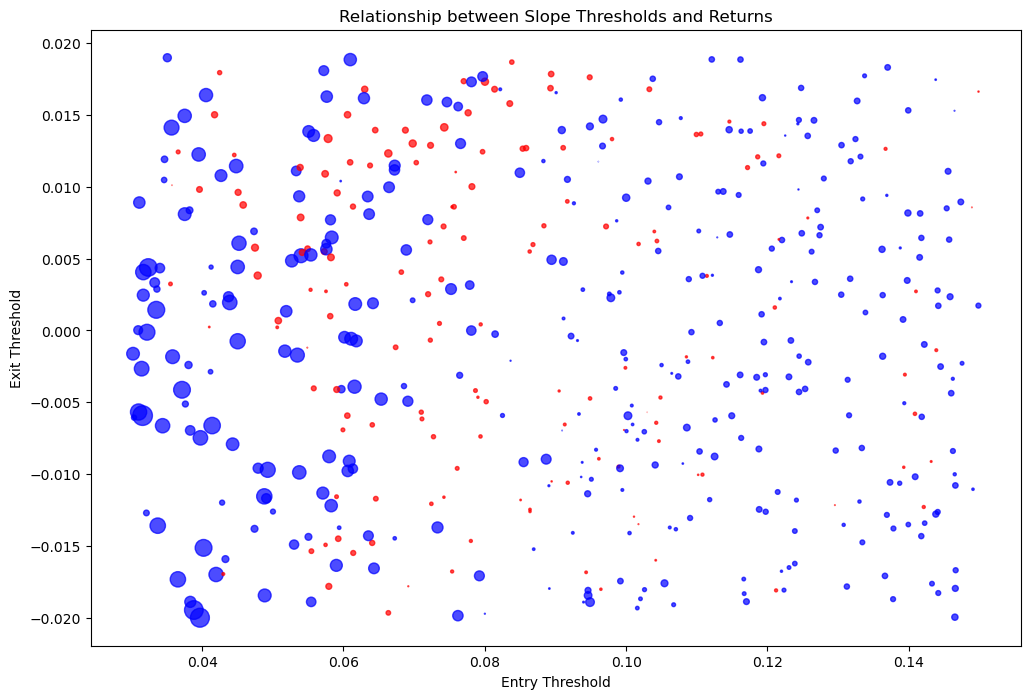

In [41]:
# Load the simulation results
with open('./simulation_results/ema_sma_test_ema_sma_simulation_results.json', 'r') as f:
    simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    x=df['ema_entry_threshold'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7                # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between Slope Thresholds and Returns')
plt.xlabel('Entry Threshold')
plt.ylabel('Exit Threshold')

# Show the plot
plt.show()


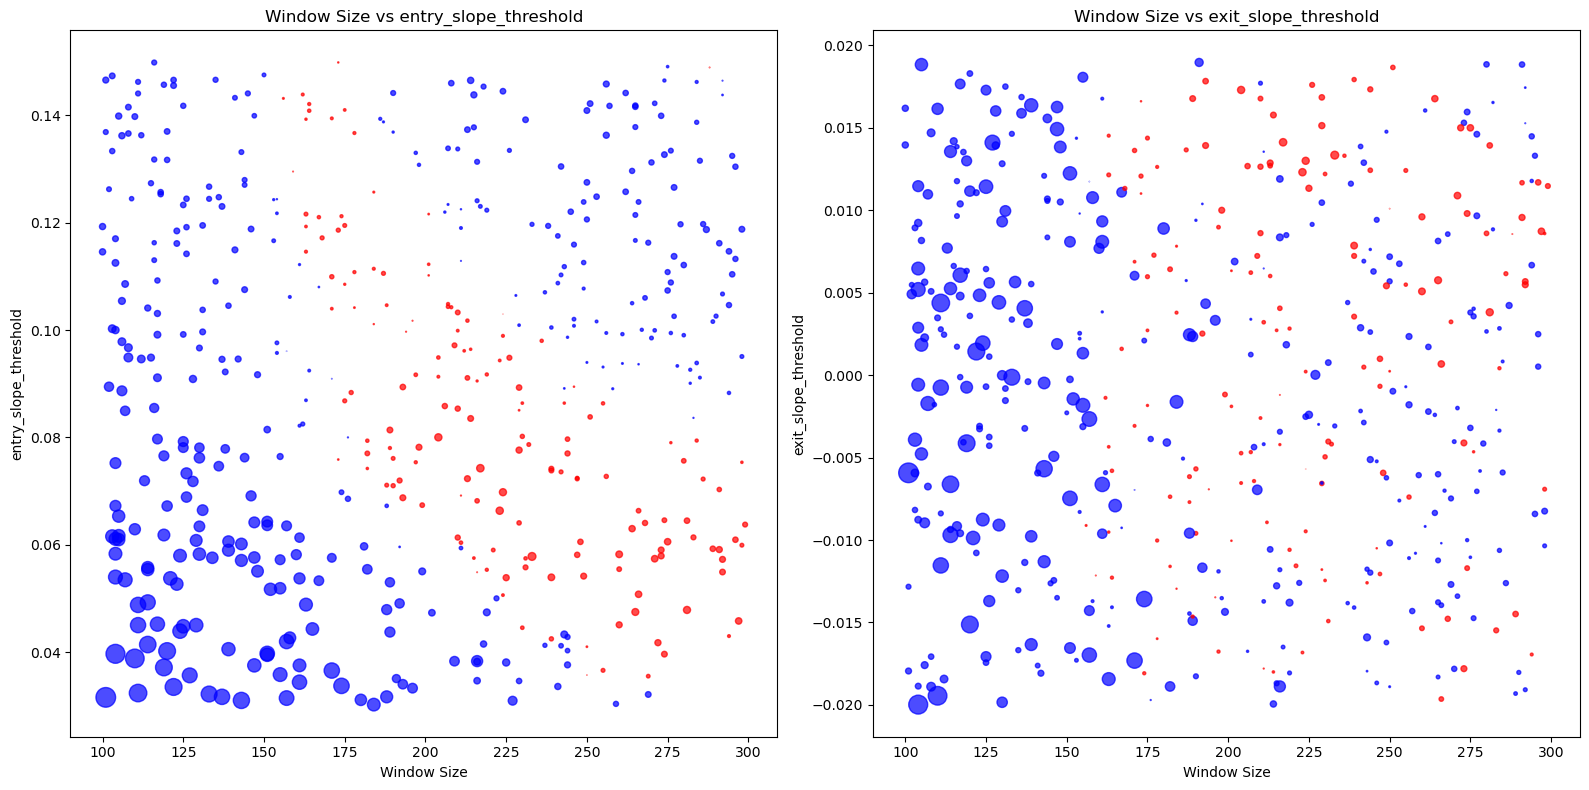

In [39]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['ema_span'],
    y=df['ema_entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['ema_span'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [40]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv'), 50, 2000)

mc_results = strategy.run_monte_carlo_simulation_with_ema_sma(
        iterations=500,
        window_range=(150, 300),
        ema_entry_threshold_range=(0.03, 0.15),
        ema_exit_threshold_range=(-0.02, 0.019),
        output_name='ema_sma_long'
)

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [42]:
# Load the simulation results
with open('./simulation_results/ema_sma_long_ema_sma_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
83,3.721406,276,276,1,0.055332,0.010844
37,-19.537280,283,283,1,0.061139,0.012891
214,-39.657934,264,264,1,0.047174,0.011226
102,-39.867593,289,289,1,0.041256,0.014404
192,-42.596333,267,267,1,0.067642,0.011466
395,-53.053965,270,270,1,0.052928,0.006144
217,-65.515029,258,258,1,0.065201,0.012830
311,-69.665224,254,254,1,0.048880,0.017315
349,-72.024392,268,268,1,0.048139,0.004205
364,-72.696108,278,278,1,0.066772,0.018312


In [43]:
sorted_df.tail(10)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
336,-1978.820258,187,187,1,0.043867,-0.019111
221,-1984.043398,150,150,1,0.043014,0.014991
344,-2051.004602,150,150,1,0.046249,-0.001074
258,-2101.240295,175,175,1,0.036455,-0.004588
269,-2195.084880,187,187,1,0.037608,-0.014234
178,-2229.504176,172,172,1,0.030408,0.000831
359,-2275.654688,170,170,1,0.031100,0.000653
25,-2282.973112,193,193,1,0.032231,-0.011857
174,-2475.681563,189,189,1,0.032139,-0.013087
196,-3307.319961,164,164,1,0.030001,-0.010651


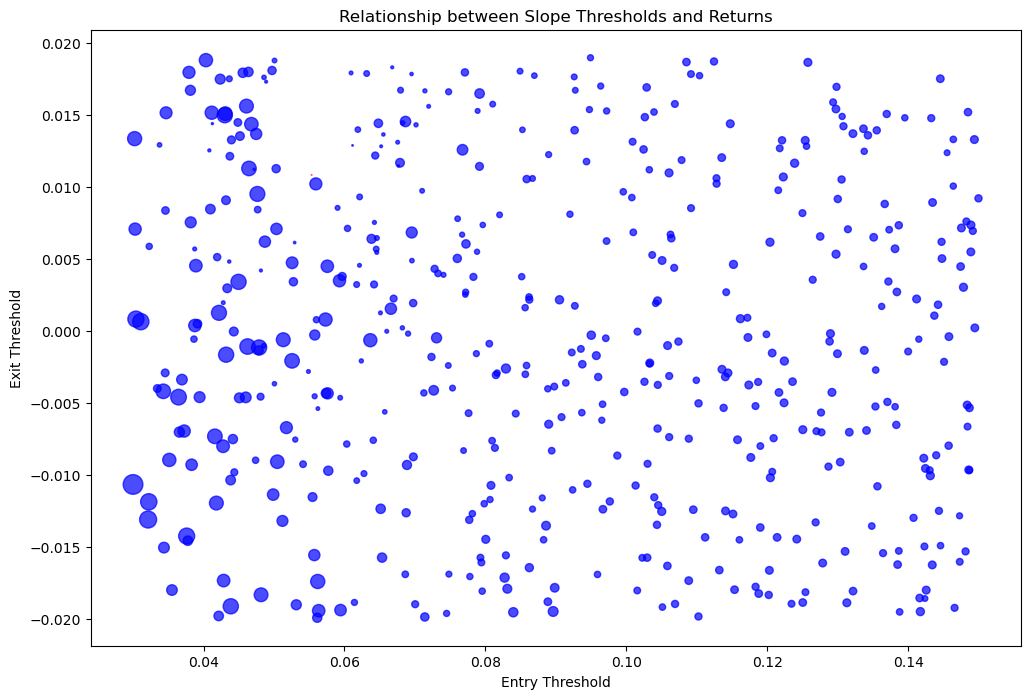

In [44]:
# Load the simulation results
with open('./simulation_results/ema_sma_long_ema_sma_simulation_results.json', 'r') as f:
    simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    x=df['ema_entry_threshold'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7                # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between Slope Thresholds and Returns')
plt.xlabel('Entry Threshold')
plt.ylabel('Exit Threshold')

# Show the plot
plt.show()


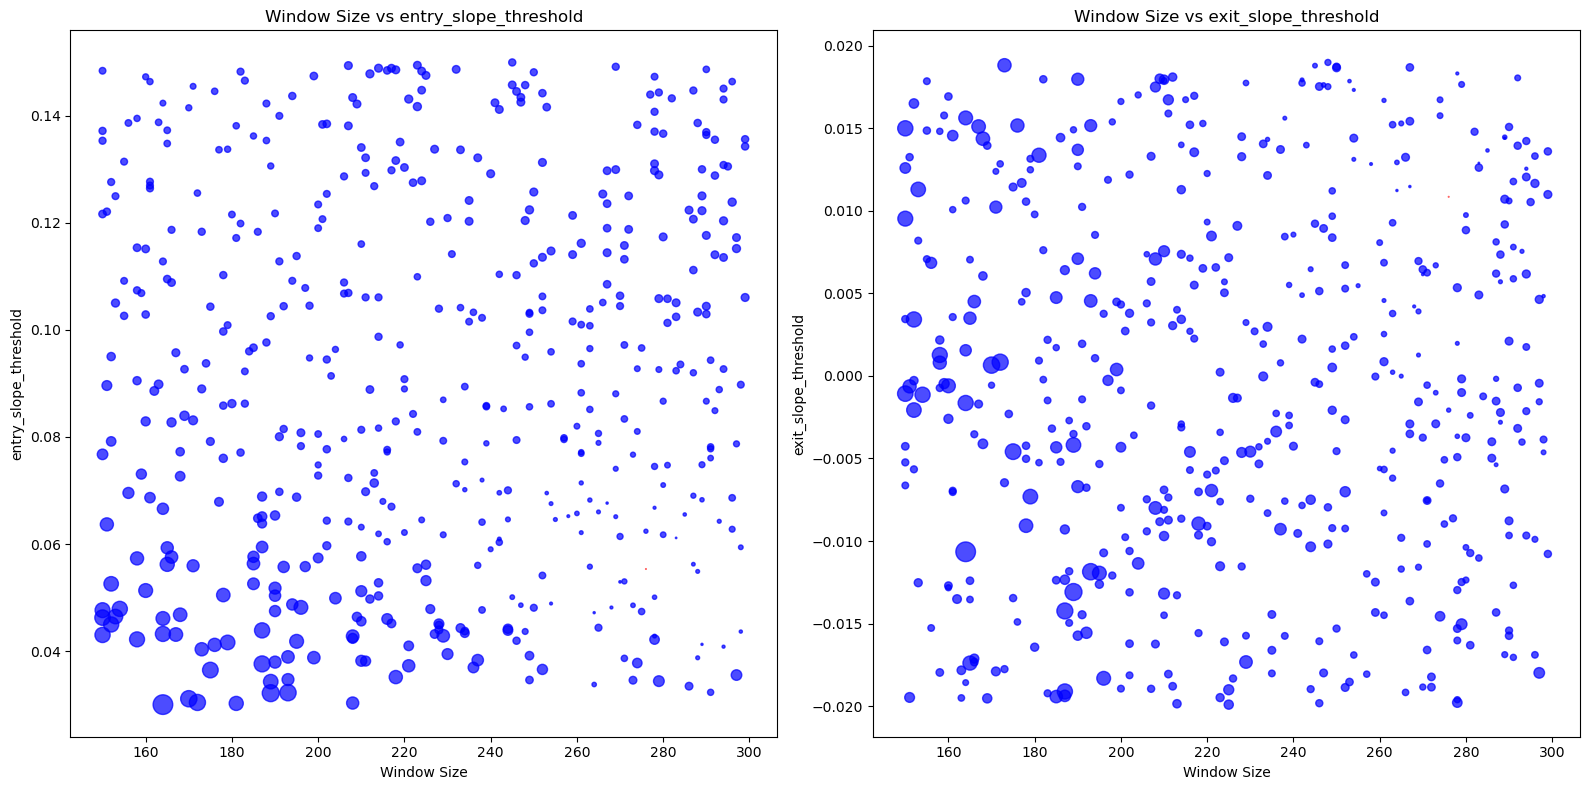

In [45]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['ema_span'],
    y=df['ema_entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['ema_span'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

In [46]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(3000), 50, 2000)

mc_results = strategy.run_monte_carlo_simulation_with_ema_sma(
        iterations=500,
        window_range=(15, 100),
        ema_entry_threshold_range=(0.03, 0.15),
        ema_exit_threshold_range=(-0.02, 0.019),
        output_name='ema_sma_small_window'
)

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:295: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)
/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_24741/3716752454.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs[market] = pd.concat([self.trade_logs[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [47]:
# Load the simulation results
with open('./simulation_results/ema_sma_small_window_ema_sma_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(30)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
418,-10.755601,92,92,1,0.116805,-0.008467
157,-13.536015,95,95,1,0.117919,0.014531
179,-18.614083,95,95,1,0.121754,-0.015001
428,-19.282911,99,99,1,0.109964,0.007244
469,-19.452742,89,89,1,0.131621,0.001232
0,-20.374751,98,98,1,0.112544,0.011906
394,-22.589300,99,99,1,0.112652,0.001906
283,-23.258458,93,93,1,0.131102,0.017919
54,-23.906659,97,97,1,0.122013,0.012478
433,-26.937272,99,99,1,0.105598,-0.012473


In [48]:
sorted_df.tail(10)

,returns,ema_span,sma_window,position_size,ema_entry_threshold,ema_exit_threshold
237,-2946.122910,16,16,1,0.063491,0.010273
229,-2985.290867,19,19,1,0.037022,0.010660
101,-3046.402457,23,23,1,0.034047,-0.015446
277,-3121.445534,17,17,1,0.057876,-0.015588
79,-3127.977411,18,18,1,0.035314,0.011724
273,-3145.064423,15,15,1,0.063040,0.016937
148,-3192.445962,17,17,1,0.044406,0.003456
365,-3264.388246,18,18,1,0.031561,0.008025
156,-3596.820262,18,18,1,0.031817,-0.009320
250,-3865.839737,15,15,1,0.033022,0.009829


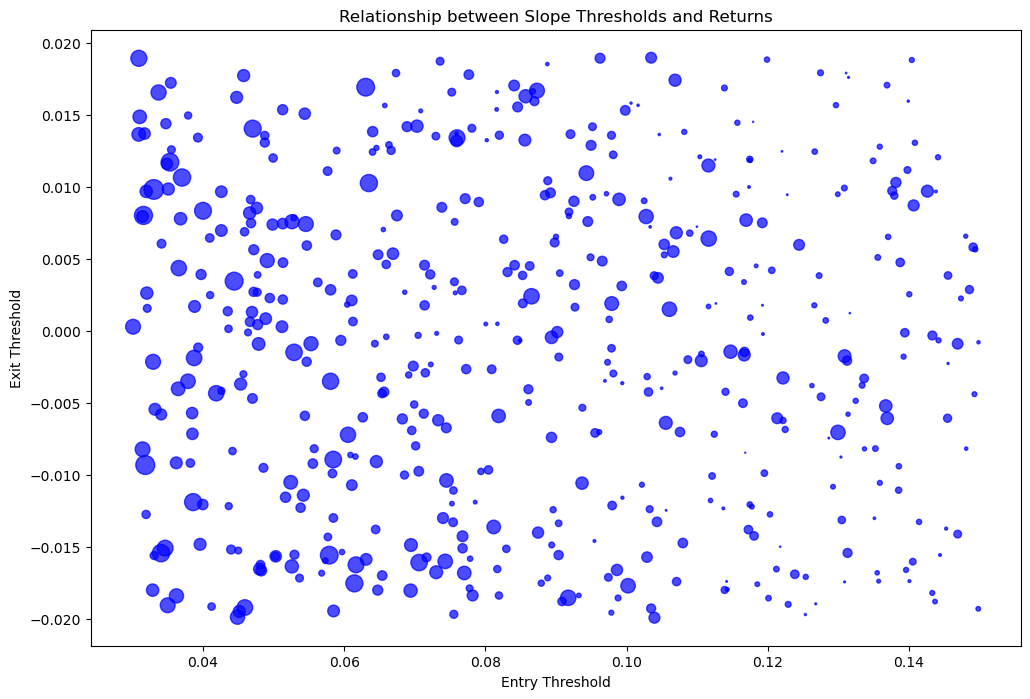

In [49]:
# Load the simulation results
with open('./simulation_results/ema_sma_small_window_ema_sma_simulation_results.json', 'r') as f:
    simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    x=df['ema_entry_threshold'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7                # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between Slope Thresholds and Returns')
plt.xlabel('Entry Threshold')
plt.ylabel('Exit Threshold')

# Show the plot
plt.show()

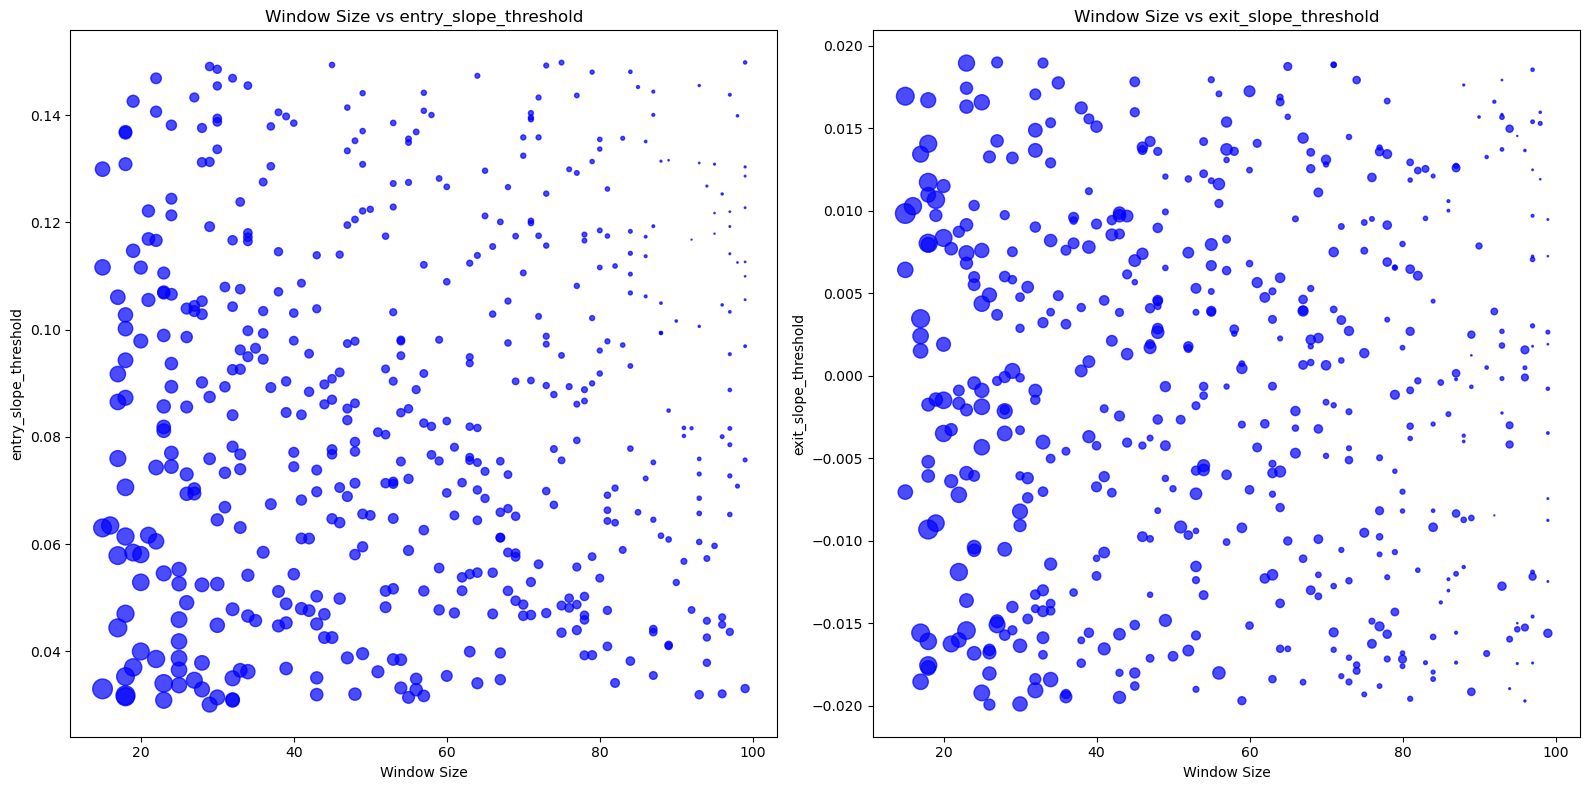

In [50]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['ema_span'],
    y=df['ema_entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_slope_threshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_slope_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['ema_span'],
    y=df['ema_exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_slope_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_slope_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()